![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.ensemble import BaggingRegressor

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [6]:
#describe de la variable "total" segun season
bikes.groupby('season').total.describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
1,2686.0,116.343261,125.273974,1.0,24.0,78.0,164.0,801.0
2,2733.0,215.251372,192.007843,1.0,49.0,172.0,321.0,873.0
3,2733.0,234.417124,197.151001,1.0,68.0,195.0,347.0,977.0
4,2734.0,198.988296,177.622409,1.0,51.0,161.0,294.0,948.0


Teniendo en cuenta que season corresponde a las estaciones (1:winter, 2:spring, 3:summer, 4:fall): 

- season=1 (invierno) es la estación en la que se alquilan menos bicicletas: 116.34 en promedio.
- season=3 (verano) es la estación en la que se alquilan más bicicletas: 234.42 en promedio. 
- En verano, el numero de alquileres de bicecletas oscila entre 1 y 977. 

In [7]:
#describe de la variable "total" segun hour
bikes.groupby('hour').total.describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,455.0,55.138462,43.620012,2.0,24.00,41.0,74.50,283.0
1,454.0,33.859031,34.112105,1.0,11.00,19.0,46.00,168.0
2,448.0,22.899554,26.110267,1.0,5.00,11.0,32.00,119.0
3,433.0,11.757506,12.666442,1.0,3.00,6.0,15.00,66.0
4,442.0,6.407240,4.217633,1.0,3.00,6.0,9.00,28.0
5,452.0,19.767699,12.784293,1.0,8.00,19.0,29.00,57.0
6,455.0,76.259341,54.745333,1.0,24.50,75.0,118.00,213.0
7,455.0,213.116484,159.207044,1.0,63.00,208.0,334.00,596.0
8,455.0,362.769231,231.723065,8.0,133.50,392.0,563.50,839.0


Teniendo en cuenta que hour corresponde a franjas horarias del día (1-23):

- hour=4 es la franja horaria (entre 4am y 5am) en la que se alquilan menos bicicletas: 6.40 en promedio.
- hour=17 es la franja horaria (entre 5pm y 6pm) en la que se alquilan más bicicletas: 468.76 en promedio.
- En este horario (hour=17), el numero de alquileres oscila entre 15 y 970. 

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot: xlabel='hour'>

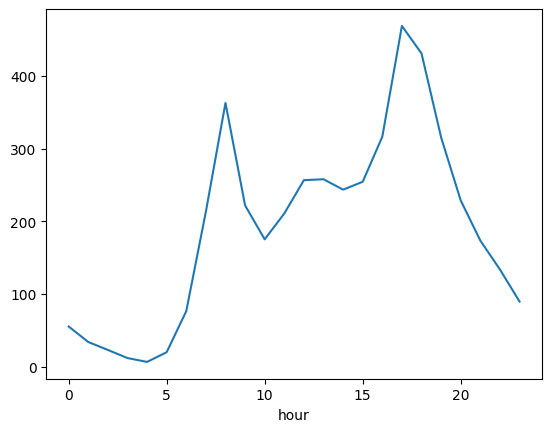

In [8]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

La gráfica anterior muestra el número total de bicicletas alquiladas en promedio por franja horaria. 

<AxesSubplot: xlabel='hour'>

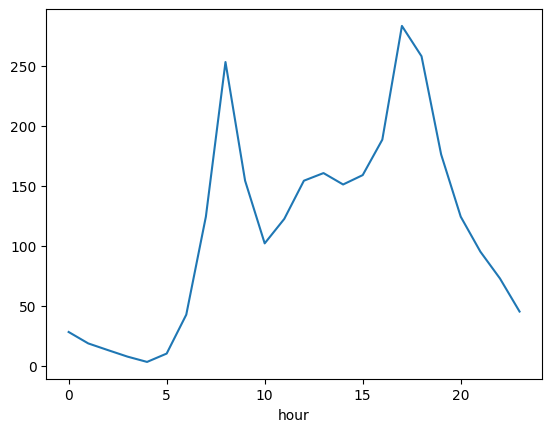

In [9]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes.season==1].groupby('hour').total.mean().plot()

<AxesSubplot: xlabel='hour'>

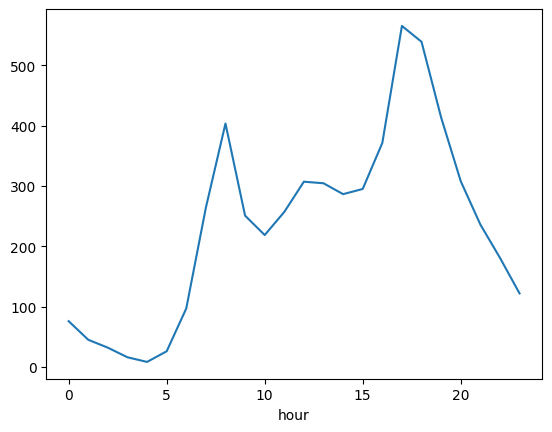

In [10]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes.season==3].groupby('hour').total.mean().plot()

<AxesSubplot: xlabel='hour'>

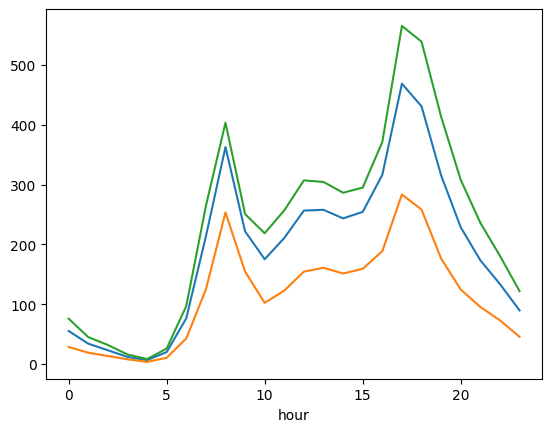

In [11]:
# 3 gráficas unificadas
bikes.groupby('hour').total.mean().plot()
bikes[bikes.season==1].groupby('hour').total.mean().plot()
bikes[bikes.season==3].groupby('hour').total.mean().plot()

- El comportamiento del total de alquileres por franja horaria en ambas estaciones (season=1 invierno, season=3 verano) es similar.
- El número total de alquileres realizados en invierno (linea naranja) es significativamente más bajo que verano (linea azul).
- En hour 5-8 el total de alquileres realizados en promedio, es creciente al igual que de 15-17 horas donde alcanza su máximo y comienza a decrecer.


### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [12]:
# Crear una lista con las variables predictoras
feature_cols = ['season', 'hour']

# Crear X (matriz de características)
X = bikes[feature_cols]

# Crear y (vector de respuesta)
y = bikes.total

#separacion train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Instanciar el modelo de regresion lineal
linreg = LinearRegression()

# Ajustar el modelo
linreg.fit(X_train, y_train)

# Imprimir los coeficientes
print("Beta0 = ",linreg.intercept_)
print("Beta1 = ",linreg.coef_[0])
print("Beta2 = ",linreg.coef_[1])

Beta0 =  2.1473084972575407
Beta1 =  26.939740519261647
Beta2 =  10.554487200290032


¿Cuáles son las limitaciones de la regresión lineal en este caso?
- Este modelo asume relación lineal entre variables.
- Al ser la variable **sesion** categorica, la interpetacion del coeficiente asociado es diferente. Dado que este es positivo se puede decir que a medida que aumenta el codigo asignado a season (1:winter, 2:spring, 3:summer, 4:fall) aumenta el número promedio de alquileres.
-  Sobre el coefiente asociado a **hour**:10.52, indica cuánto cambia la variable dependiente **(total)** por cada unidad de cambio en la variable independiente **(hour)**.


In [14]:
#prediciones modelo
y_pred = linreg.predict(X_test)

#calculo r2
r2= r2_score(y_test, y_pred)

#calculo mse
mse= mean_squared_error(y_test, y_pred)

#calculo rmse
rmse= np.sqrt(mse)

print("Desempeño Modelo LinearRegression:")
print("R cuadrado: ", r2)
print("MSE: ", mse)
print("RMSE: ", rmse)

Desempeño Modelo LinearRegression:
R cuadrado:  0.18507204048105586
MSE:  26898.27489446689
RMSE:  164.0069355072123


### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [15]:
import numpy as np
import pandas as pd

# Definición de parámetros y criterios de parada
max_depth = 3
num_pct = 10
min_gain = 0.001

# Asumiendo que X e y ya están definidos como tus características y objetivo respectivamente

# Función para calcular el error cuadrático medio (MSE)
def mse(y):
    if y.shape[0] == 0:
        return 0
    else:
        return np.mean((y - y.mean())**2)

# Función para calcular la impureza del MSE
def mse_impurity(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]

    n_l = y_l.shape[0]
    n_r = y_r.shape[0]

    mse_y = mse(y)
    mse_l = mse(y_l)
    mse_r = mse(y_r)

    mse_impurity_ = mse_y - (n_l / (n_l + n_r) * mse_l + n_r / (n_l + n_r) * mse_r)

    return mse_impurity_

# Función para obtener la mejor división
def best_split(X, y, num_pct=10):
    features = range(X.shape[1])

    best_split = [0, 0, 0]  # j, split, gain

    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]

        for split in splits:
            gain = mse_impurity(X.iloc[:, j], y, split)

            if gain > best_split[2]:
                best_split = [j, split, gain]

    return best_split

def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, gain=0)
        return tree

    j, split, gain = best_split(X, y, num_pct)
    
    y_pred = y.mean()
    
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)

    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   

    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)

    return tree

def tree_predict(X, tree):
    if tree['split'] == -1:
        return np.ones(X.shape[0]) * tree['y_pred']
    else:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]
        
        predicted = np.zeros(X.shape[0])
        predicted[filter_l] = tree_predict(X_l, tree['sl'])
        predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        return predicted

tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)

predictions = tree_predict(X, tree)


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [16]:
max_depth_range = range(1, 21)
r2_scores = []

for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeRegressor de la librería sklearn
    clf = DecisionTreeRegressor(max_depth=depth, random_state=1)
    # Entrenamiento del modelo usando los datos de entrenamiento
    clf.fit(X_train, y_train)
    # Predicción del modelo usando los datos de prueba
    y_pred = clf.predict(X_test)
    # Cálculo del R cuadrado del modelo
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

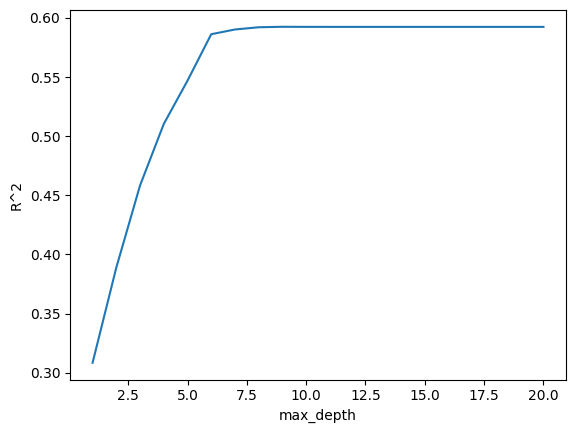

In [17]:
plt.plot(max_depth_range, r2_scores)
plt.xlabel('max_depth')
plt.ylabel('R^2')
plt.show()

In [18]:
best_depth = max_depth_range[np.argmax(r2_scores)]
print('La mejor profundidad es:', best_depth)

La mejor profundidad es: 9


In [19]:
clf = DecisionTreeRegressor(max_depth=best_depth, random_state=1)
clf.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=9, random_state=1)

In [20]:
#Predicciones modelo
y_pred = clf.predict(X_test)

#calculo r2
r2= r2_score(y_test, y_pred)

#calculo mse
mse= mean_squared_error(y_test, y_pred)

#calculo rmse
rmse= np.sqrt(mse)

print("Desempeño Modelo DecisionTreeRegressor:")
print("R cuadrado: ", r2)
print("MSE: ", mse)
print("RMSE: ", rmse)

Desempeño Modelo DecisionTreeRegressor:
R cuadrado:  0.5924685874754883
MSE:  13451.363196184311
RMSE:  115.98001205459633


In [21]:
# Uso de la función .feature_importances_ para obtener la importancia de cada variable
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
0,season,0.135838
1,hour,0.864162


- El desempeño mejoró significativamente respecto al modelo de regresión lineal, pasando de un R2 de 0.185 a 0.592 pero sigue siendo bajo.
- El RMSE mejoró respecto al modelo de regresión Lineal, pasando de 164.01 a 115.98.
- Pese que el modelo DecisionTreeRegressor mejora significativamente el desempeño del modelo respecto al LinearRegression, el desempeño aún no es óptimo. Cabe resatar que sólo se esta modelando con 2 predictores (season, hour), donde la mayor importancia la tiene "hour" (0,86). Se sugiere explorar la inclusión de otros predictores que permitan mejorar el desempeño.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [22]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [23]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [24]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [25]:
#regresion logistica
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

#desempeño regresion logística
Accuracy_logreg=accuracy_score(y_test, y_pred)
F1_Score_logreg=f1_score(y_test, y_pred)
print('Accuracy logreg: ', Accuracy_logreg)
print('F1 Score logreg: ', F1_Score_logreg)

Accuracy logreg:  0.614
F1 Score logreg:  0.6106254203093476


In [26]:
#arbol de decision
max_depth_range = range(1, 21)
accuracy_scores = []

for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la librería sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    # Entrenamiento del modelo usando los datos de entrenamiento
    clf.fit(X_train, y_train)
    # Predicción del modelo usando los datos de prueba
    y_pred = clf.predict(X_test)
    # Cálculo del accuracy del modelo
    accuracy=accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

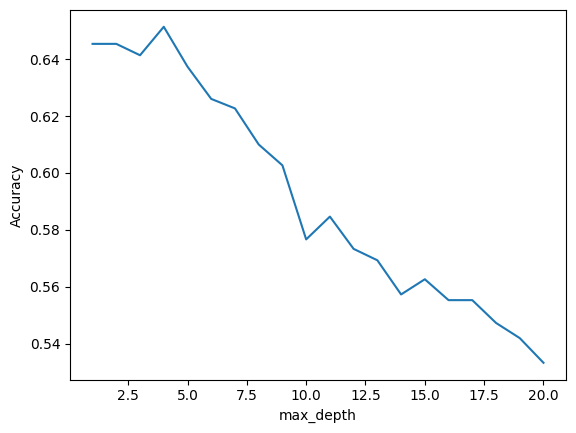

In [27]:
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show()

In [28]:
best_depth = max_depth_range[np.argmax(accuracy_scores)]
print('La mejor profundidad es:', best_depth)

La mejor profundidad es: 4


In [29]:
clf = DecisionTreeClassifier(max_depth=best_depth, random_state=1)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=1)

In [30]:
#predicciones arbol de decision
y_pred = clf.predict(X_test)

#desempeño arbol de decision
Accuracy=accuracy_score(y_test, y_pred)
F1_Score=f1_score(y_test, y_pred)
print('Accuracy: ', Accuracy)
print('F1 Score: ', F1_Score)

Accuracy:  0.6513333333333333
F1 Score:  0.6345213137665969


- El desempeño mejoró usando DecisionTreeClassifier respecto al modelo de LogisticRegression, pasando de un Accuracy de 0.61 a 0.65.
- De forma similar el F1_Score mejoró, pasando de 0.61 con LogisticRegression a 0.63 con DecisionTreeClassifier.
- Pese que el modelo DecisionTreeClassifier mejora ligeramente el desempeño del modelo respecto al LogisticRegression, el desempeño aún es óptimo. Se sugiere explorar alternativas adicionales que permitan mejorar el desempeño.
- La mejora del desempeño de los modelos, tras la aplicación de árboles de decisión fue más marcada en el caso de regresión que en el de clasificación.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [31]:
# Creación de 100 árboles de decisión con max_depth=3 y 100 árboles de decisión con min_samples_leaf=5
tree1 = DecisionTreeClassifier(max_depth=3)
tree2 = DecisionTreeClassifier(min_samples_leaf=5)
bagging_tree1 = BaggingClassifier(tree1, n_estimators=100, random_state=1)
bagging_tree2 = BaggingClassifier(tree2, n_estimators=100, random_state=1)

# Creación de 100 regresiones logísticas
logistic = LogisticRegression()
bagging_logistic=BaggingClassifier(logistic, n_estimators=100, random_state=1)

# Entrenamiento de los modelos individuales
bagging_tree1.fit(X_train, y_train)
bagging_tree2.fit(X_train, y_train)
bagging_logistic.fit(X_train, y_train)

# Evaluación de los modelos individuales
y_pred_tree1 = bagging_tree1.predict(X_test)
y_pred_tree2 = bagging_tree2.predict(X_test)
y_pred_logistic = bagging_logistic.predict(X_test)

accuracy1=accuracy_score(y_test, y_pred_tree1)
f1_score1=f1_score(y_test, y_pred_tree1)

accuracy2=accuracy_score(y_test, y_pred_tree2)
f1_score2=f1_score(y_test, y_pred_tree2)

accuracy3=accuracy_score(y_test, y_pred_logistic)
f1_score3=f1_score(y_test, y_pred_logistic)

print("Evaluación de los modelos individuales:")
print("Decision Tree 1: ", accuracy1,  "F1-Score; ", f1_score1)
print("Decision Tree 2: ", accuracy2,  "F1-Score; ", f1_score2)
print("Logistic Regression: ", accuracy3,  "F1-Score; ", f1_score3)

Evaluación de los modelos individuales:
Decision Tree 1:  0.6513333333333333 F1-Score;  0.6454237288135594
Decision Tree 2:  0.6446666666666667 F1-Score;  0.6458471760797342
Logistic Regression:  0.6213333333333333 F1-Score;  0.6167341430499326


In [32]:
# Ensamble por votación mayoritaria
ensamble1 = VotingClassifier(estimators=[
    ('tree1', bagging_tree1),
    ('tree2', bagging_tree2),
    ('logistic', bagging_logistic)
], voting='hard')

# Entrenamiento del ensamble por votación mayoritaria
ensamble1.fit(X_train, y_train)

# Evaluación del ensamble
y_pred_ensamble1 = ensamble1.predict(X_test)

accuracy_ensamble1=accuracy_score(y_test, y_pred_ensamble1)
f1_score_ensamble1=f1_score(y_test, y_pred_ensamble1)


print("Evaluación ensamble 1 por votación mayoritaria:")
print("Accuracy :", accuracy_ensamble1,"f1_score: ", f1_score_ensamble1 )

Evaluación ensamble 1 por votación mayoritaria:
Accuracy : 0.652 f1_score:  0.6482479784366577


Los modelos con muestras bagged para: 
- 100 árboles de decisión donde max_depth=3
- 100 árboles de decisión donde min_samples_leaf=5

Tienen desempeño similar con accuracy de apox 0.65 y F1-Score de 0.64. 

- La regresion logistica, tiene menor desempeño con acuuracy y F1-Score de aprox. 0.62. 

El ensamble por votación mayoritaria, tiene acuuracy y F1-Score de aprox. 0.65, luego no presenta mejora significativa respecto a los modelos anteriores con arboles de decision. 



### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [33]:
# Ensamble por votación ponderada
ensamble2 = VotingClassifier(estimators=[
    ('tree1', bagging_tree1),
    ('tree2', bagging_tree2),
    ('logistic', bagging_logistic)
], voting='soft')

# Entrenamiento del ensamble por votación ponderada
ensamble2.fit(X_train, y_train)

# Evaluación del ensamble
y_pred_ensamble2 = ensamble2.predict(X_test)

accuracy_ensamble2=accuracy_score(y_test, y_pred_ensamble2)
f1_score_ensamble2=f1_score(y_test, y_pred_ensamble2)


print("Evaluación ensamble 2 por votación ponnderada:")
print("Accuracy :", accuracy_ensamble2,"f1_score: ", f1_score_ensamble2 )

Evaluación ensamble 2 por votación ponnderada:
Accuracy : 0.6546666666666666 f1_score:  0.656042496679947


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

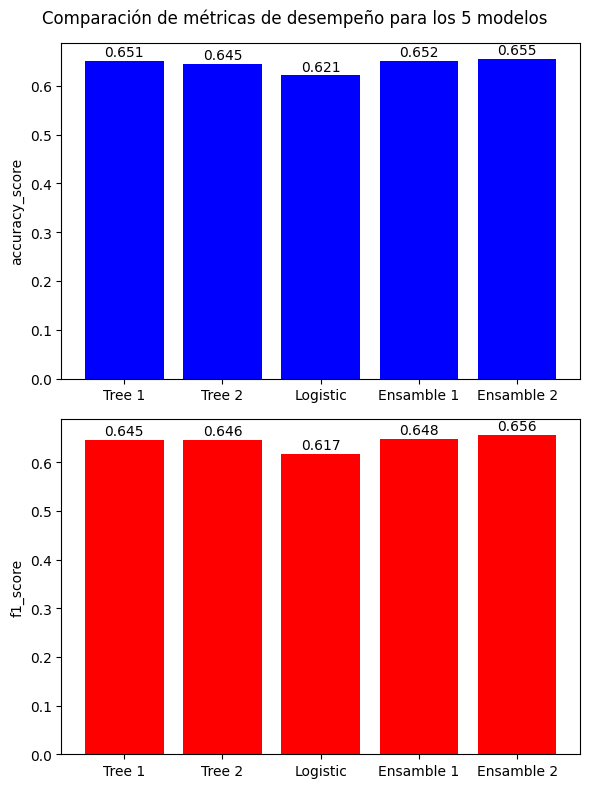

In [34]:
# Crear una lista con los valores de las métricas para cada modelo
accuracy_scores = [accuracy1, accuracy2, accuracy3, accuracy_ensamble1, accuracy_ensamble2]
f1_scores = [f1_score1, f1_score2, f1_score3, f1_score_ensamble1, f1_score_ensamble2]


# Definir las etiquetas para el eje X
models = ['Tree 1', 'Tree 2', 'Logistic', 'Ensamble 1', 'Ensamble 2']


# Crear una figura con dos subgráficos verticales
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))


# Crear un gráfico de barras para accuracy_score
ax1.bar(models, accuracy_scores, color='blue')
ax1.set_ylabel('accuracy_score')


# Añadir los valores de accuracy_score encima de las barras
for i, score in enumerate(accuracy_scores):
    ax1.text(i, score + 0.01, str(round(score, 3)), ha='center')
    

# Crear un gráfico de barras para f1_score
ax2.bar(models, f1_scores, color='red')
ax2.set_ylabel('f1_score')


# Añadir los valores de f1_score encima de las barras
for i, score in enumerate(f1_scores):
    ax2.text(i, score + 0.01, str(round(score, 3)), ha='center')

# Añadir títulos y ajustar la disposición de los subgráficos
plt.suptitle('Comparación de métricas de desempeño para los 5 modelos')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

El ensamblaje puede mejorar significativamente el desempeño de un modelo pero esto depende de varios factores, como la calidad de los modelos base, la diversidad entre los modelos base y el método de ensamblaje utilizado.En algunos casos, el ensamblaje puede incluso empeorar el desempeño del modelo si los modelos base son débiles o no están suficientemente diversificados. Además, el ensamblaje también puede aumentar la complejidad y el tiempo de entrenamiento del modelo.

En este caso, los ensambles realizados teniendo en cuenta los 3 modelos originales, no mejoran significativamente el desempeño del modelo, obteniendo resultados similares a los de los árboles de decisión. 